In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [2]:
# Load the XML file
tree = ET.parse('export.xml')  # Replace with your actual file path
root = tree.getroot()

In [3]:
# Initialize list to hold step count data
step_data = []

# Loop through all elements in the XML
for record in root.findall('Record'):
    if record.attrib.get('type') == 'HKQuantityTypeIdentifierStepCount':
        creation_date = record.attrib.get('creationDate')
        value = record.attrib.get('value')
        step_data.append((creation_date, value))

In [4]:
# Create dataframe for steps data
df_steps = pd.DataFrame(step_data, columns=['creationDate', 'stepCount'])

In [5]:
df_steps.head()

,creationDate,stepCount
0,2019-10-12 18:24:58 -0400,5
1,2019-10-12 20:00:10 -0400,55
2,2019-10-12 11:58:46 -0400,51
3,2019-10-12 12:09:05 -0400,20
4,2019-10-12 20:25:23 -0400,20


In [6]:
df_steps['creationDate'] = pd.to_datetime(df_steps['creationDate']).dt.date
df_steps['stepCount'] = pd.to_numeric(df_steps['stepCount'])

In [7]:
df_steps.head()

,creationDate,stepCount
0,2019-10-12,5
1,2019-10-12,55
2,2019-10-12,51
3,2019-10-12,20
4,2019-10-12,20


In [8]:
# Group by creationDate, summing up the stepCount
daily_steps = df_steps.groupby('creationDate', as_index=False)['stepCount'].sum()

In [9]:
daily_steps.head()

,creationDate,stepCount
0,2019-10-12,151
1,2019-10-13,7398
2,2019-10-14,8423
3,2019-10-15,7955
4,2019-10-16,4838


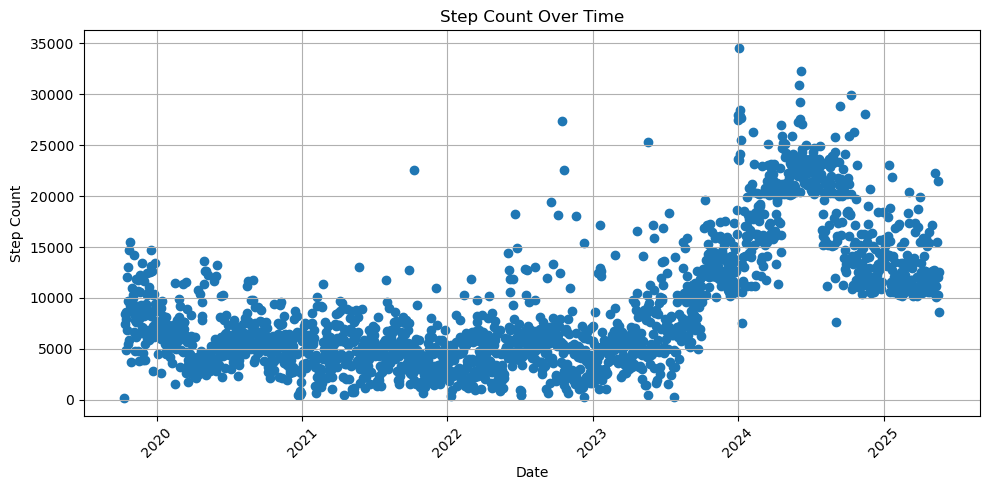

In [10]:
# Plot all the step data
plt.figure(figsize=(10, 5))
plt.scatter(daily_steps['creationDate'], daily_steps['stepCount'], marker='o')
plt.title('Step Count Over Time')
plt.xlabel('Date')
plt.ylabel('Step Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Convert 'creationDate' to datetime
daily_steps['creationDate'] = pd.to_datetime(daily_steps['creationDate'])

# Filter for 2024 and up
df_steps_2024 = daily_steps[daily_steps['creationDate'] >= pd.Timestamp('2024-01-01')]

In [12]:
df_steps_2024.head()

,creationDate,stepCount
1542,2024-01-01,28005
1543,2024-01-02,27516
1544,2024-01-03,23592
1545,2024-01-04,34572
1546,2024-01-05,27838


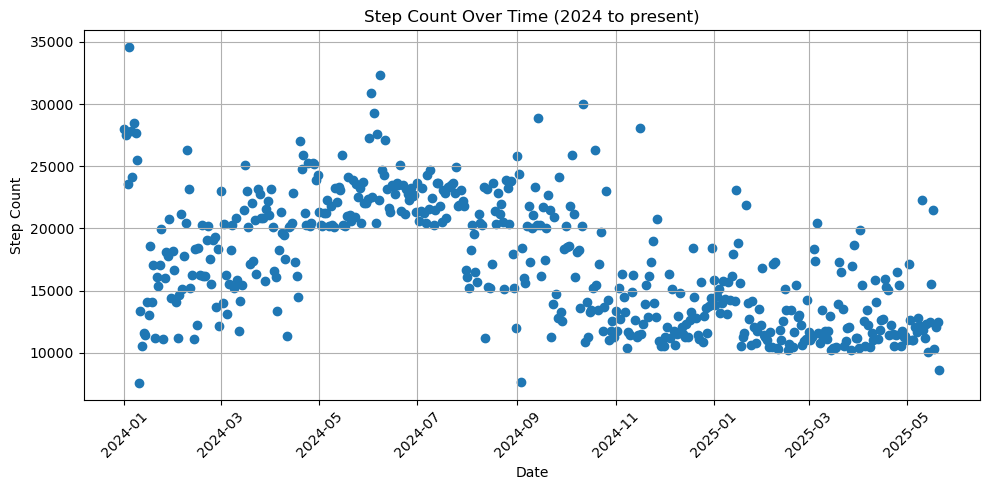

In [13]:
# Plot filtered steps data
plt.figure(figsize=(10, 5))
plt.scatter(df_steps_2024['creationDate'], df_steps_2024['stepCount'], marker='o')
plt.title('Step Count Over Time (2024 to present)')
plt.xlabel('Date')
plt.ylabel('Step Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Initialize list to hold weight data
weight_data = []

# Loop through all elements in the XML
for record in root.findall('Record'):
    if record.attrib.get('type') == 'HKQuantityTypeIdentifierBodyMass':
        creation_date = record.attrib.get('creationDate')
        value = record.attrib.get('value')
        weight_data.append((creation_date, value))

In [15]:
# Create dataframe for weight data
df_weight = pd.DataFrame(weight_data, columns=['creationDate', 'weight'])

In [16]:
df_weight.head()

,creationDate,weight
0,2019-10-24 04:12:34 -0400,212
1,2019-10-30 04:24:59 -0400,211.6
2,2019-11-03 06:35:33 -0400,212.8
3,2019-11-17 07:14:27 -0400,210.2
4,2019-11-24 05:50:54 -0400,213.6


In [17]:
df_weight['creationDate'] = pd.to_datetime(df_weight['creationDate']).dt.date
df_weight['weight'] = pd.to_numeric(df_weight['weight'])

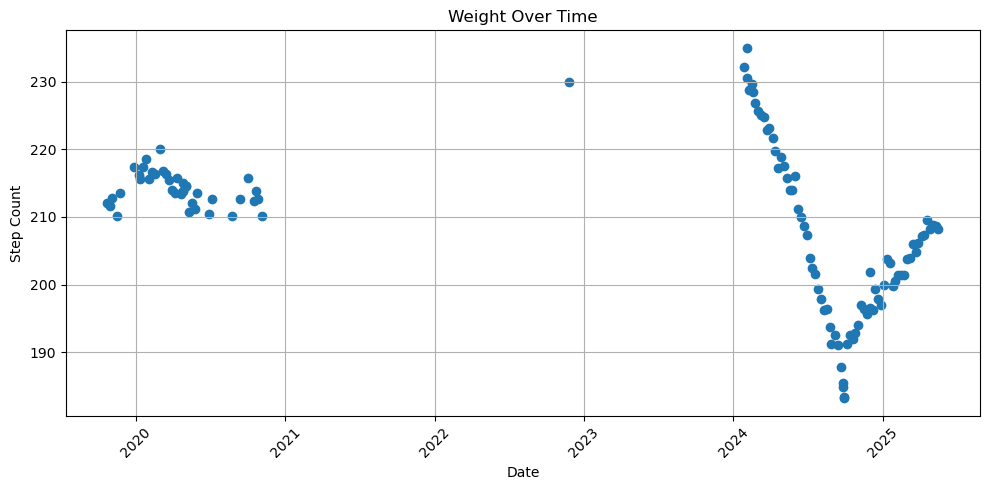

In [18]:
# Plot all weight data
plt.figure(figsize=(10, 5))
plt.scatter(df_weight['creationDate'], df_weight['weight'], marker='o')
plt.title('Weight Over Time')
plt.xlabel('Date')
plt.ylabel('Step Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Convert 'creationDate' to datetime
df_weight['creationDate'] = pd.to_datetime(df_weight['creationDate'])

# Filter to only use data from 2024 and up
df_weight_2024 = df_weight[df_weight['creationDate'] >= pd.Timestamp('2024-01-01')]

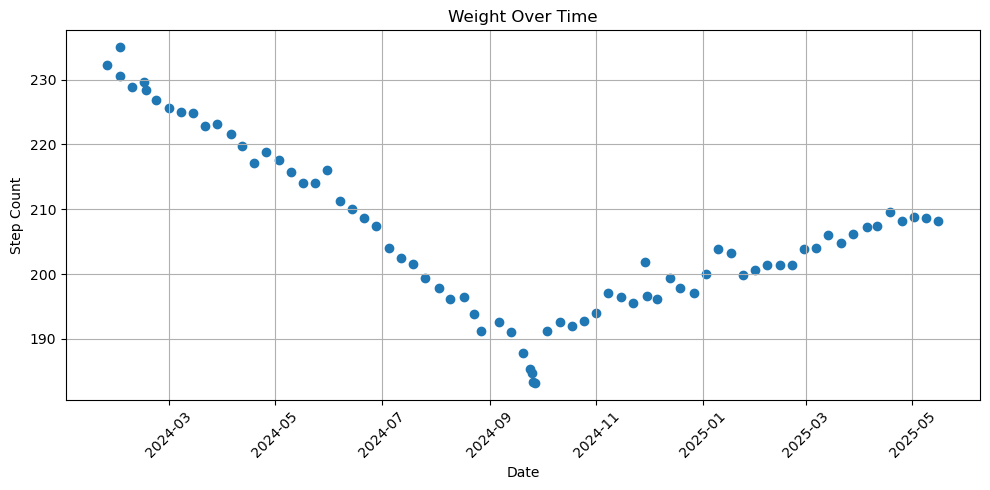

In [20]:
# Plot the filtered weight data
plt.figure(figsize=(10, 5))
plt.scatter(df_weight_2024['creationDate'], df_weight_2024['weight'], marker='o')
plt.title('Weight Over Time')
plt.xlabel('Date')
plt.ylabel('Step Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Set index to 'creationDate' for df_steps_2024 to make rolling easier
df_steps_2024 = df_steps_2024.set_index('creationDate').sort_index()

In [22]:
# Compute 7-day centered rolling average on stepCount
df_steps_2024['stepAvg7d'] = df_steps_2024['stepCount'].rolling(window=7, center=True).mean()

In [23]:
# Reset index to merge later
df_steps_2024 = df_steps_2024.reset_index()

In [24]:
# Merge on exact dates where both DataFrames align
merged_df = pd.merge(
    df_weight_2024,
    df_steps_2024[['creationDate', 'stepAvg7d']],
    on='creationDate',
    how='inner'
)
merged_df['stepAvg7d'] = merged_df['stepAvg7d'].round(0).astype('Int64')

In [25]:
merged_df.head()

,creationDate,weight,stepAvg7d
0,2024-01-26,232.2,17265
1,2024-02-02,230.6,15757
2,2024-02-02,235.0,15757
3,2024-02-09,228.8,19184
4,2024-02-16,229.6,16129


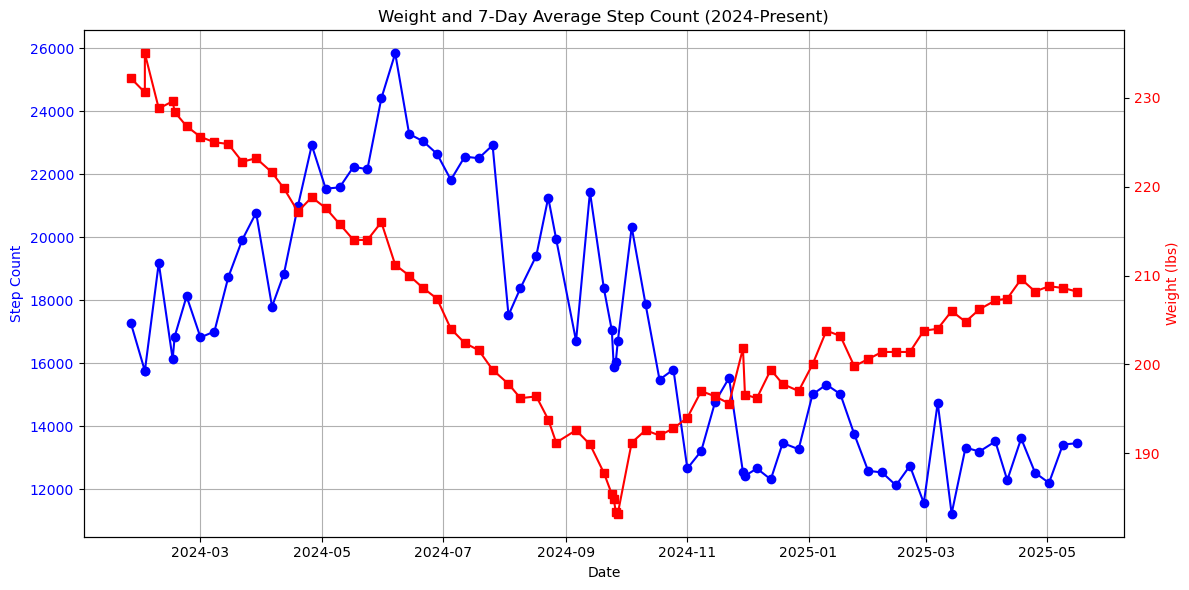

In [26]:
# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Step Count (left y-axis)
ax1.plot(merged_df['creationDate'], merged_df['stepAvg7d'], color='blue', marker='o', label='7-Day Avg Steps')
ax1.set_xlabel('Date')
ax1.set_ylabel('Step Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create second y-axis for weight
ax2 = ax1.twinx()
ax2.plot(merged_df['creationDate'], merged_df['weight'], color='red', marker='s', label='Weight')
ax2.set_ylabel('Weight (lbs)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout
plt.title('Weight and 7-Day Average Step Count (2024-Present)')
plt.xticks(rotation=45)
fig.tight_layout()

plt.show()
